In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2 
import numpy as np
import os 
import time
import scipy.io as sc

In [ ]:
cd /content/gdrive/MyDrive/Señales 3/Dataset_Emotion/

/content/gdrive/MyDrive/Señales 3/Dataset_Emotion


In [ ]:
#data = sc.loadmat('/content/gdrive/MyDrive/Señales3/Dataset_Emotion/')
path = ('/content/gdrive/MyDrive/Señales 3/Dataset_Emotion')
lista = os.listdir(path) #convierte el contenido del pat en una lista 
print(path,lista)

labels = []
data = []
label = 0

for directorio in lista:
    emocionpath = path +'/'+ directorio # accedemos a la carpeta de cada emocion
    for imagen in os.listdir(emocionpath):
        data.append(cv2.imread(emocionpath +'/'+imagen,0)) # agregar imagenes
        labels.append(label) # agregar etiquetas 
    
    label= label+1

/content/gdrive/MyDrive/Señales 3/Dataset_Emotion ['enfado', 'feliz', 'asco', 'triste', 'sorpresa', 'neutral']


In [ ]:
## EigenFaces ##
labels =np.asarray(labels)
EigenFaces_recognizer = cv2.face.EigenFaceRecognizer_create() # creamos el objeto LBPH
EigenFaces_recognizer.train(data,labels) # entrenamos el algoritmo con las imagenes del dataset
#vect = EigenFaces_recognizer.getEigenVectors() # histogramas (características)
vect = EigenFaces_recognizer.getEigenVectors()

vect = np.asarray(vect)
vect = vect.reshape(331,122500)
np.savetxt('caracteristicas_EF.csv',vect,delimiter=',',fmt="%f")
np.savetxt('labels.csv',labels,delimiter=' ',fmt='%s')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt


data = pd.read_csv("caracteristicas_EF.csv").to_numpy()
labels = pd.read_csv("labels.csv").to_numpy()
labels = labels.reshape(330)

data_norm = (data - np.mean(data))/np.std(data) #normalizamos los datos 
lw=2
target_names = ['asco','enfado','feliz', 'neutral','sorpresa','triste']
colors =['orange','green','blue','red','black','pink']

<Figure size 432x288 with 0 Axes>

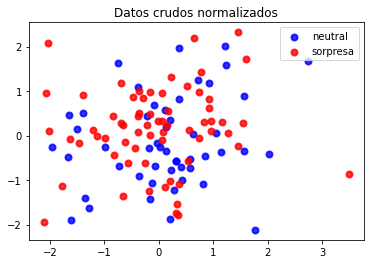

<Figure size 432x288 with 0 Axes>

In [ ]:
#%% Datos crudos
target_names = ['neutral','sorpresa']
colors=['blue','red']
for color, i, target_name in zip(colors, [3,4], target_names):
    plt.scatter(data_norm[labels == i, 0], data_norm[labels == i, 1], color=color, alpha=.8,lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Datos crudos normalizados')
plt.figure()

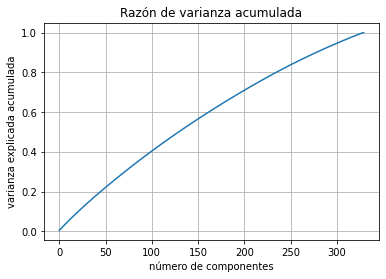

In [ ]:
#%% PCA Razón de varianza acumulada 

pca = PCA().fit(data_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Razón de varianza acumulada')
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');
plt.grid()

<Figure size 432x288 with 0 Axes>

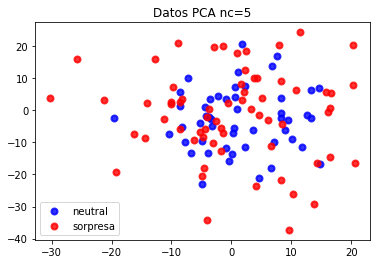

<Figure size 432x288 with 0 Axes>

In [ ]:
#%% PCA (análisis de componentes principales)
target_names = ['neutral','sorpresa']
colors=['blue','red']
pcaObj = PCA(n_components=250)
pca = pcaObj.fit_transform(data_norm)
for color, i, target_name in zip(colors, [3,4], target_names):
    plt.scatter(pca[labels == i, 0], pca[labels == i, 1], color=color, alpha=.8,lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Datos PCA nc=5')
plt.figure()

# Nueva sección